# TP 1 Mesures de performance
Dans ce TP, nous aimerions avoir un premier aperçu sur les algorithmes d'apprentissage automatique. Plus précisément, nous aimerions évaluer leurs performances en utilisant les métriques suivantes:
- Matrice de confusion
- Rappel
- Précision
- Taux de FP
- Spécificité
- Courbe ROC

Les mesures devront être calculées sur la tâche de classification des nombres manuscrits.

Le travail consiste à implementer ces métriques et à les comparer avec les métriques des librairies disponibles.

Les algorithmes : K plus Proches Voisins devront être implementés.

# Importation des librairies necessaires au travail

In [1]:
pip install numpy pandas matplotlib seaborn scikit-learn tensorflow


Note: you may need to restart the kernel to use updated packages.


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import random
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

# Lecture des fichiers de données à classifier
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [3]:
# données
X = np.genfromtxt('data.csv', delimiter=',', dtype=int)
print(X.shape)
df = pd.read_csv("data.csv",nrows=5000)

(5000, 400)


In [4]:
# étiquettes
Y = np.genfromtxt('labels.csv', delimiter=',', dtype=int)
Y.shape

(5000,)

Afficher aléatoirement quelques données de notre base

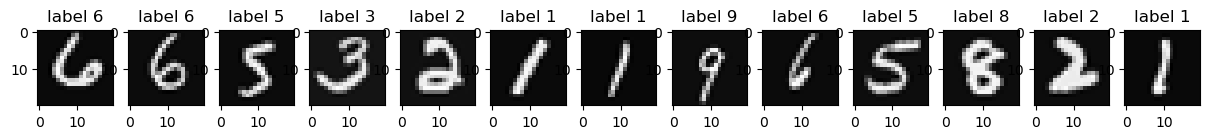

In [5]:
plt.figure(figsize=(15,8))
for i in range(13): #note: each 500 lines, there is a new value
    c = random.randint(X.shape[0]) #pick a random line from the dataset 
    a = X[c,:].reshape((20, 20)) #shape of one number in the image 
    a=np.transpose(a) # la transposé (rendre les ligne des colonne et vice versa)
    plt.subplot(1,13,i+1)
    plt.title('label '+ str(Y[c]))
    plt.imshow(a,cmap='gray')

Notons que l'étiquette 10 concerne le chiffre 0. L'étiquette a été utilisée ainsi afin de faciliter les calculs conséquents.

# Implémentation des métriques demandées
Ici il faut écrire les fonctions, puis les appeler dans la suite du code

- Matrice de confusion :

In [50]:
def compute_confusion_matrix(y_true, y_pred):
    """Calcule la matrice de confusion sous forme de dictionnaire."""
    if y_true.shape != y_pred.shape:
        raise ValueError("Les dimensions de y_true et y_pred ne correspondent pas !")

    classes = np.unique(np.concatenate((y_true, y_pred)))
    conf_matrix = {}

    for cls in classes:
        tp = np.sum((y_true == cls) & (y_pred == cls))
        fp = np.sum((y_true != cls) & (y_pred == cls))
        fn = np.sum((y_true == cls) & (y_pred != cls))
        tn = np.sum((y_true != cls) & (y_pred != cls))

        conf_matrix[cls] = {"TP": tp, "FP": fp, "FN": fn, "TN": tn}

    return conf_matrix


- Accuracy = (TP + TN)/(TP + TN + FP + FN)

In [51]:
def compute_accuracy(tp, tn, fp, fn):
    return (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) != 0 else 0


- Recall (True Positive Rate) = TP/(TP + FN)

In [52]:
def compute_recall(tp, fn):
    """Calcule le rappel (Recall = TP / (TP + FN))"""
    return (tp / (tp + fn)) if (tp + fn) != 0 else 0


- Précision = TP/(TP + FP)

In [53]:
def compute_precision(tp, fp):
    return (tp / (tp + fp)) if (tp + fp) != 0 else 0


- Taux de FP (False Positive Rate) = FP / (FP + TN)

In [54]:
def compute_fpr(fp, tn):
    return (fp / (fp + tn)) if (fp + tn) != 0 else 0

- Spécificité (True Negative Rate) = TN / (TN + FP)

In [55]:
def compute_specificity(tn, fp):
    return (tn / (tn + fp)) if (tn + fp) != 0 else 0

- Courbe ROC

In [26]:

def plot_roc_curve(y_true, y_scores, num_classes):
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve((y_true == i).astype(int), y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Classification

D'abord nromaliser les données: Mettre chaque colonne de X à une échelle avec moyenne = 0 et écart-type = 1, ce qui est utile pour de nombreux algorithmes (SVM, régression logistique...).
Ensuite définir la base d'entrainement Xt, Yt et la base de test Xtt, Ytt.


In [21]:
scaler = StandardScaler()
scaler.fit(X) #Calcule la moyenne et l'écart type de X
scaled_features = scaler.transform(X) #données normalisées (features)
Xt, Xtt, Yt, Ytt = train_test_split(
      scaled_features, Y, test_size = 0.30)

# Méthode 0: K- Plus Proches Voisins

Ici il faudra implémenter la méthode, puis la tester et vérifier les métriques en variant le nombre K

In [22]:
from collections import Counter

def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

class KNNClassifier:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        predictions = [self._predict(x) for x in X_test]
        return np.array(predictions)

    def _predict(self, x):
        # Calculer les distances
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        # Trier les indices des K plus proches voisins
        k_indices = np.argsort(distances)[:self.k]
        # Trouver les labels correspondants
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        # Voter pour la classe majoritaire
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]


Entraînement et test du modèle

In [23]:
# Instanciation du modèle avec k=3
knn = KNNClassifier(k=3)

# Entraînement sur l’ensemble d’apprentissage
knn.fit(Xt, Yt)

# Prédictions sur l’ensemble de test
Y_pred = knn.predict(Xtt)


In [56]:
for cls, values in conf_matrix.items():
    tp, fp, fn, tn = values["TP"], values["FP"], values["FN"], values["TN"]
    acc = compute_accuracy(tp, tn, fp, fn)
print(f"  - Accuracy: {acc:.2f}")

rec = compute_recall(tp, fn)
print(f"  - Recall: {rec:.2f}")

prec = compute_precision(tp, fp)
print(f"  - Précision: {prec:.2f}")

fpr = compute_fpr(fp, tn)
print(f"  - FPR: {fpr:.2f}")

spec = compute_specificity(tn, fp)
print(f"  - Spécificité: {spec:.2f}\n")

 

  - Accuracy: 0.99
  - Recall: 0.98
  - Précision: 0.95
  - FPR: 0.01
  - Spécificité: 0.99



Comparaison avec sklearn et test avec différents K ('objectif de "Comparaison avec sklearn et test avec différents K" est d'évaluer l'impact du choix de K dans l'algorithme des K-plus proches voisins (KNN) et de comparer notre implémentation avec celle de scikit-learn.)

In [60]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

K_values = [1, 3, 5, 7, 10]  # Différentes valeurs de K
results = {}

for k in K_values:
    # Initialisation du modèle avec K
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Entraînement du modèle
    knn.fit(Xt, Yt)
    
    # Prédictions sur l'ensemble de test
    Y_pred = knn.predict(Xtt)
    
    # Calcul des métriques
    accuracy = accuracy_score(Ytt, Y_pred)
    report = classification_report(Ytt, Y_pred, output_dict=True)
    
    # Stockage des résultats
    results[k] = {
        "Accuracy": accuracy,
        "Precision": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"]
    }

# Affichage des résultats
for k, metrics in results.items():
    print(f"K = {k}: Accuracy = {metrics['Accuracy']:.4f}, Precision = {metrics['Precision']:.4f}, Recall = {metrics['Recall']:.4f}")


K = 1: Accuracy = 0.8720, Precision = 0.8729, Recall = 0.8720
K = 3: Accuracy = 0.8733, Precision = 0.8760, Recall = 0.8733
K = 5: Accuracy = 0.8720, Precision = 0.8737, Recall = 0.8720
K = 7: Accuracy = 0.8727, Precision = 0.8751, Recall = 0.8727
K = 10: Accuracy = 0.8733, Precision = 0.8751, Recall = 0.8733


Tracer la courbe ROC

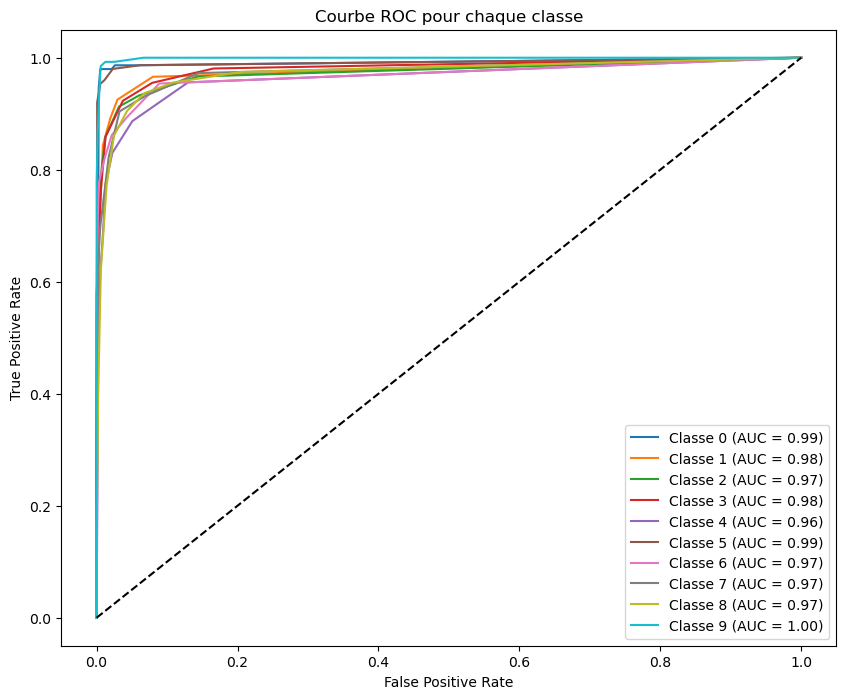

In [61]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarisation des étiquettes
num_classes = len(np.unique(Y))
Ytt_bin = label_binarize(Ytt, classes=np.unique(Y))
Y_scores = knn_sklearn.predict_proba(Xtt)  # Prédictions de probabilités

# Tracer la courbe ROC pour chaque classe
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(Ytt_bin[:, i], Y_scores[:, i])  # ROC pour chaque classe
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Classe {i} (AUC = {roc_auc:.2f})')

# Ligne aléatoire (baseline)
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC pour chaque classe')
plt.legend()
plt.show()



# Méthode 1: MVS
Machine à Vecteurs de Support

In [ ]:
#Créer le modèle
model= svm.SVC(kernel='linear') 
# entrainement 
model.fit(Xt, Yt)
# Prediction
y_pred = model.predict(Xtt)

9


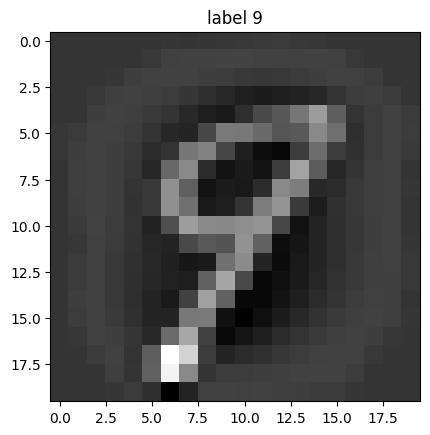

In [ ]:
# tester une image
c= 3
print (y_pred[c])
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')

# Méthode 2: Arbres de décision


In [ ]:
# Créer le modèle
model = DecisionTreeClassifier()
# Entrainer le modèle
model = model.fit(Xt, Yt)
# Prediction
y_pred = model.predict(Xtt)

9


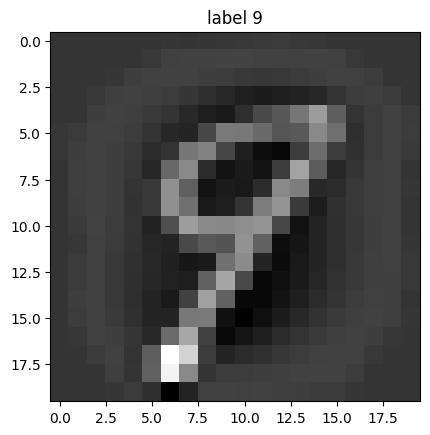

In [ ]:
# tester une image
c= 3
print (y_pred[c])
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')

In [ ]:

# Data preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, Y, test_size=0.3, random_state=42
)

# Train decision tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Make predictions
y_pred = dt_model.predict(X_test)
y_pred_proba = dt_model.predict_proba(X_test)


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       164
           1       0.91      0.89      0.90       152
           2       0.73      0.68      0.71       155
           3       0.71      0.64      0.68       154
           4       0.78      0.76      0.77       143
           5       0.64      0.73      0.68       141
           6       0.84      0.82      0.83       143
           7       0.78      0.78      0.78       158
           8       0.66      0.70      0.68       132
           9       0.72      0.73      0.72       158

    accuracy                           0.77      1500
   macro avg       0.77      0.77      0.77      1500
weighted avg       0.77      0.77      0.77      1500


retraining the DT model on another dataset 

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Chargement du dataset MNIST
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist["data"], mnist["target"].astype(int)

# Normalisation des données
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Division en données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Entraînement du modèle Decision Tree
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_scores = model.predict_proba(X_test)

| Classe | Accuracy | Recall | Precision | FPR   | Specificity |
|--------|----------|--------|-----------|-------|-------------|
| 0      | 0.9844   | 0.9319 | 0.9121    | 0.0098| 0.9902      |
| 1      | 0.9894   | 0.9613 | 0.9451    | 0.0071| 0.9929      |
| 2      | 0.9711   | 0.8484 | 0.8600    | 0.0153| 0.9847      |
| 3      | 0.9689   | 0.8417 | 0.8513    | 0.0167| 0.9833      |
| 4      | 0.9744   | 0.8740 | 0.8651    | 0.0147| 0.9853      |
| 5      | 0.9686   | 0.8266 | 0.8253    | 0.0174| 0.9826      |
| 6      | 0.9794   | 0.8858 | 0.9022    | 0.0105| 0.9895      |
| 7      | 0.9809   | 0.9116 | 0.9054    | 0.0111| 0.9889      |
| 8      | 0.9656   | 0.8095 | 0.8327    | 0.0176| 0.9824      |
| 9      | 0.9661   | 0.8347 | 0.8257    | 0.0194| 0.9806      |

# Méthode 3: RN 
Réseaux de neurones Perceptron

In [ ]:
model = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(25),max_iter=100000)
model.fit(Xt, Yt)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=25, max_iter=100000, solver='sgd')

In [ ]:
# Choisir une image de test 
c=0

In [ ]:
model.predict([Xtt[c,:]])

array([10])

In [ ]:
# pour ROC, il faudra les probabilités:
model.predict_proba([Xtt[c,:]])

array([[2.42915527e-39, 1.34991428e-36, 2.36571030e-14, 5.53879916e-27,
        1.45335221e-68, 7.65573695e-88, 1.29441094e-45, 4.32153866e-35,
        1.94890418e-49, 1.00000000e+00]])

Afficher l'image testée

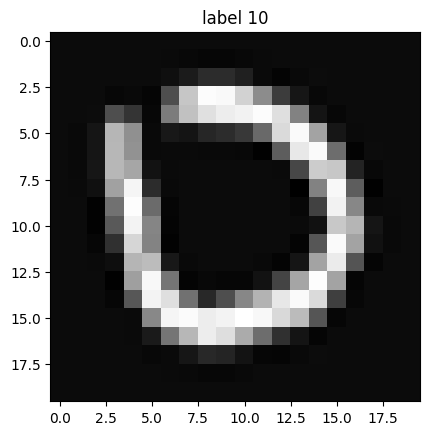

In [ ]:
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')

# Appliquer les métriques implementées pour voir le résultat et comparer les avec celles des librairies de python

# Refaire le processus sur un autre dataset de votre choix (exemple: iris...)